In [10]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
# pd.set_option('display.max_columns', 50)

In [11]:
# Load data
df = pd.read_csv("../data/Training Data_Case 3.csv", index_col=0)

In [12]:
# df = df.tail(252)

<Axes: >

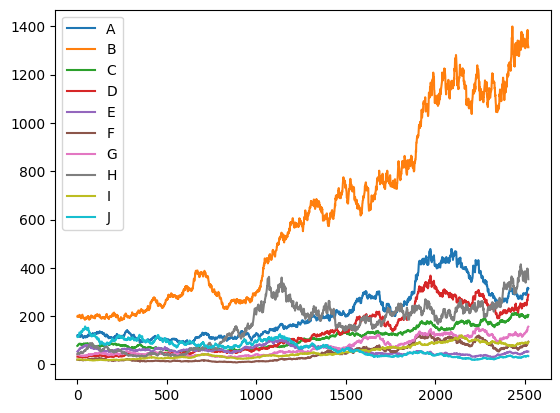

In [13]:
df.plot()

In [14]:
class Projections:
    # Get daily % returns given prices
    def make_df(self, df):
        df['shift']=df[df.columns[0]].shift(1)
        df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
        df=df.drop(columns='shift')
        return df
    # Generate list of projections
    def gen_data(self, df, first_day, runs, days):
        
        # Create list of arrays with projected daily returns
        data=[]
        first_prices=[]
        for x in range(len(df.columns)):
            temp=self.make_df(df.iloc[:,x:x+1])
            first_prices.append(temp[temp.columns[0]].iloc[first_day-1])
            data.append(np.random.laplace(loc=temp['PctChg'].mean(), scale=temp['PctChg'].std(), size=(runs, days)))
        
        # Get projected prices by applying % changes
        proj_dfs=[]
        for asset_num in range(len(data)):
            
            asset_data=[]
            for n in range(len(data[asset_num])):
                prices=[first_prices[asset_num]]
                for x in range(len(data[asset_num][n])):
                    prices.append(prices[x]*(100+data[asset_num][n][x])/100)
                asset_data.append(prices)
            
            proj_arr=np.array(asset_data)
            proj_df=pd.DataFrame()
            for x in range(proj_arr.shape[0]):
                proj_df[str(x)]=proj_arr[x]
            proj_dfs.append(proj_df)
            
        # Transform dataframes
        dfs=[]
        for run_num in range(proj_dfs[0].shape[1]):
            temp=pd.DataFrame()
            for asset_num in range(len(proj_dfs)):
                prev_df=proj_dfs[asset_num]
                temp[str(asset_num)]=prev_df[prev_df.columns[run_num]]
            dfs.append(temp)
            
        return dfs

In [15]:
class GeneticAlgorithm:
    def __init__(self, df):
        self.year_num = np.sqrt(252)
        self.returns = df
        self.high_fitness_weights = {}
        self.convergence_count = []
    
    def gen_weights(self, df):
        weights=np.random.randint(0, 100000, len(df.columns))
        weights=weights/sum(weights)
        return weights
    
    def gen_population(self, num_chrom, df):
        population=[]
        for x in range(num_chrom):
            population.append(self.gen_weights(df))
        return np.array(population)
    
    def evaluate_chrom(self, chromosome, dfs):    
        sharpes=[]
        for x in range(len(dfs)):
            temp=dfs[x].multiply(chromosome, axis=1)
            test=temp[list(temp.columns)].sum(axis=1).pct_change()
            sharpe=(test.mean()/test.std())*self.year_num
            sharpes.append(sharpe)
        return np.mean(sharpes)
    
    def evaluate_population(self, pop, proj_dfs):
        sharpes=[]
        for chrom in pop:
            sharpes.append(self.evaluate_chrom(chrom, proj_dfs))
        return np.array(sharpes)
    
    # Choose chromosome for next generation given the cumulataive normalized sharpes
    def choose_chrom(self, population, cum_norm_sharpes):
        for n in range(len(cum_norm_sharpes)):
            if cum_norm_sharpes[n]>np.random.rand(1)[0]:
                return population[n]
            
    def crossover(self, chrom1, chrom2):
        if np.random.rand(1)[0]>.5:
            return np.concatenate((chrom1[:int(len(chrom1)/2)], chrom2[int(len(chrom1)/2):]), axis=None)
        else:
            return np.concatenate((chrom2[:int(len(chrom1)/2)], chrom1[int(len(chrom1)/2):]), axis=None)
        
    def mutate(self, chrom, rate):
        new=[]
        for weight in chrom:
            if np.random.rand(1)[0]<rate:
                new_weight=weight*(1+np.random.normal(0, .4, 1)[0])
                if(new_weight<0):
                    new.append(0)
                else:
                    new.append(new_weight)
            else:
                new.append(weight)
        return np.array(new)
    
    def rebalance(self, chrom):
        return chrom/sum(chrom)
    
    # Create next generation of chromosomes (weights)
    def next_gen(self, sharpes, population, mutation_rate):
        
        new_gen=[]
        
        # Select best fourth
        num_chosen_direct=round(len(population)/4)
        temp={}
        for x in range(len(sharpes)):
            temp[x]=sharpes[x]
        temp={k: v for k, v in sorted(temp.items(), key=lambda item: item[1])}
        keys=list(temp.keys())[-1*num_chosen_direct:]
        for x in keys:
            new_gen.append(population[x])
        
        # Select rest through crossover: create cumulative norm fitness list
        norm_sharpes=sharpes/sum(sharpes)
        cum_norm_sharpes=[norm_sharpes[0]]
        for n in range(1, len(norm_sharpes)):
            cum_norm_sharpes.append(cum_norm_sharpes[n-1]+norm_sharpes[n])
        for x in range(len(population)-num_chosen_direct):
            new_gen.append(self.crossover(self.choose_chrom(population, cum_norm_sharpes), self.choose_chrom(population, cum_norm_sharpes)))
            
        # Mutation and rebalance
        final=[]
        for x in new_gen:
            final.append(self.rebalance(self.mutate(x, mutation_rate)))
            
        return np.array(final)
    
    def genetic_algo(self, prev_gen_sharpes, prev_gen, pop_size, mutation_rate, df, proj_dfs):
        
        # Add to high fitness weights dict
        # high_fitness_weights = {}
        max_sharpe=max(prev_gen_sharpes)
        best_weights=prev_gen[list(prev_gen_sharpes).index(max_sharpe)]
        self.high_fitness_weights[max_sharpe]=best_weights
        
        # Check convergence
        # convergence_count = []
        convergence=False
        if (len(self.high_fitness_weights)==30):
            convergence=True
        elif (len(self.high_fitness_weights)>1):
            if max_sharpe<list(self.high_fitness_weights.keys())[-2]*1.02:
                self.convergence_count.append(1)
            else:
                self.convergence_count.append(0)

            if (sum(self.convergence_count[-20:])==20):
                convergence=True
            else:
                convergence=False
        else:
            self.convergence_count.append(0)
        
        # Recursive GA
        if (convergence==False):
            print("Generation Number "+str(len(self.convergence_count)+1))
            print("---Processing")
            print("---Sharpe: "+str(max_sharpe))
            new_gen=self.next_gen(prev_gen_sharpes, prev_gen, mutation_rate)
            new_gen_sharpes=self.evaluate_population(new_gen, proj_dfs)
            print("---Done")
            self.genetic_algo(new_gen_sharpes, new_gen, pop_size, mutation_rate, df, proj_dfs)
        else:
            print("Convergence achieved")

In [21]:
projections = Projections()
proj_dfs = projections.gen_data(df, first_day = len(df)-30, runs = 50, days = 30)

# Define GA inputs
pop_size=25
mutation_rate=.5

model = GeneticAlgorithm(df)
gen1 = model.gen_population(pop_size, df)

# Run GA
sharpes=model.evaluate_population(gen1, proj_dfs)
# high_fitness_weights={}
# convergence_count=[]
model.genetic_algo(sharpes, gen1, pop_size, mutation_rate, df, proj_dfs)

C:\Users\redce\AppData\Local\Temp\ipykernel_23532\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_23532\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_23532\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 1.9060903713320183
---Done
Generation Number 3
---Processing
---Sharpe: 2.0211110540554658
---Done
Generation Number 4
---Processing
---Sharpe: 1.9119077965116804
---Done
Generation Number 5
---Processing
---Sharpe: 1.9671388959663443
---Done
Generation Number 6
---Processing
---Sharpe: 1.9231793465213394
---Done
Generation Number 7
---Processing
---Sharpe: 1.9017754486800802
---Done
Generation Number 8
---Processing
---Sharpe: 1.9505478788884028
---Done
Generation Number 9
---Processing
---Sharpe: 2.0114807865306643
---Done
Generation Number 10
---Processing
---Sharpe: 2.015361641296415
---Done
Generation Number 11
---Processing
---Sharpe: 2.0268602985564605
---Done
Generation Number 12
---Processing
---Sharpe: 2.0361280109324515
---Done
Generation Number 13
---Processing
---Sharpe: 2.0121986125926377
---Done
Generation Number 14
---Processing
---Sharpe: 2.068441693225186
---Done
Generation Number 15
---Processing
---Sharpe: 2.0381075607724

In [20]:
max_sharpe=max(list(model.high_fitness_weights.items()))[0]
best_weights=max(list(model.high_fitness_weights.items()))[1]
print("Max Sharpe: "+str(max_sharpe))
print("Associated Weights: "+str(best_weights))

ValueError: max() arg is an empty sequence

In [ ]:
start = 126

sharpe_ratios = []
for i in range(start,len(df)-126):
    if i > 126*2 and i % 126 == 0:
        projections = Projections()
        proj_dfs = projections.gen_data(df[:i], first_day = i-126, runs = 50, days = 126)

        # Define GA inputs
        pop_size=25
        mutation_rate=.5

        model = GeneticAlgorithm(df[:i])
        gen1 = model.gen_population(pop_size, df[:i])

        # Run GA
        sharpes=model.evaluate_population(gen1, proj_dfs)
        high_fitness_weights={}
        convergence_count=[]
        model.genetic_algo(sharpes, gen1, pop_size, mutation_rate, df[:i], proj_dfs)
        
        max_sharpe=max(list(high_fitness_weights.items()))[0]
        best_weights=max(list(high_fitness_weights.items()))[1]
        
        sharpe_ratios.append(max_sharpe)
        print("Max Sharpe: "+str(max_sharpe))
        print("Associated Weights: "+str(best_weights))


C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 0.5307481204832176
---Done
Generation Number 3
---Processing
---Sharpe: 0.5577195585080919
---Done
Generation Number 4
---Processing
---Sharpe: 0.5803547010796405
---Done
Generation Number 5
---Processing
---Sharpe: 0.6289829597926112
---Done
Generation Number 6
---Processing
---Sharpe: 0.639406399196988
---Done
Generation Number 7
---Processing
---Sharpe: 0.6725488550150109
---Done
Generation Number 8
---Processing
---Sharpe: 0.6677992923258994
---Done
Generation Number 9
---Processing
---Sharpe: 0.6693562115106925
---Done
Generation Number 10
---Processing
---Sharpe: 0.6878180777765845
---Done
Generation Number 11
---Processing
---Sharpe: 0.670742238526336
---Done
Generation Number 12
---Processing
---Sharpe: 0.6898408328594157
---Done
Generation Number 13
---Processing
---Sharpe: 0.692989103821253
---Done
Generation Number 14
---Processing
---Sharpe: 0.6906355764879762
---Done
Generation Number 15
---Processing
---Sharpe: 0.69228689606022

C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 0.49670601655419944
---Done
Generation Number 3
---Processing
---Sharpe: 0.49559938780981555
---Done
Generation Number 4
---Processing
---Sharpe: 0.6842544919462152
---Done
Generation Number 5
---Processing
---Sharpe: 0.8609758293300374
---Done
Generation Number 6
---Processing
---Sharpe: 0.8804038686672787
---Done
Generation Number 7
---Processing
---Sharpe: 0.8629109988168634
---Done
Generation Number 8
---Processing
---Sharpe: 1.0276521716560785
---Done
Generation Number 9
---Processing
---Sharpe: 1.051776044998542
---Done
Generation Number 10
---Processing
---Sharpe: 1.2028474064381147
---Done
Generation Number 11
---Processing
---Sharpe: 1.2232289127556415
---Done
Generation Number 12
---Processing
---Sharpe: 1.247914871215941
---Done
Generation Number 13
---Processing
---Sharpe: 1.247505030522765
---Done
Generation Number 14
---Processing
---Sharpe: 1.2506314578443412
---Done
Generation Number 15
---Processing
---Sharpe: 1.271641402713

C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 0.7297507636967902
---Done
Generation Number 3
---Processing
---Sharpe: 0.7456978869884671
---Done
Generation Number 4
---Processing
---Sharpe: 0.7564294782610408
---Done
Generation Number 5
---Processing
---Sharpe: 0.8408882309059686
---Done
Generation Number 6
---Processing
---Sharpe: 0.8092815332186483
---Done
Generation Number 7
---Processing
---Sharpe: 0.8049535018816872
---Done
Generation Number 8
---Processing
---Sharpe: 0.8612241447473689
---Done
Generation Number 9
---Processing
---Sharpe: 0.8685966812881937
---Done
Generation Number 10
---Processing
---Sharpe: 0.9018955681386831
---Done
Generation Number 11
---Processing
---Sharpe: 0.9259467833750746
---Done
Generation Number 12
---Processing
---Sharpe: 0.9262841980718636
---Done
Generation Number 13
---Processing
---Sharpe: 0.9441449235955706
---Done
Generation Number 14
---Processing
---Sharpe: 0.9578153856664846
---Done
Generation Number 15
---Processing
---Sharpe: 0.93716791921

C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 0.5786180239752553
---Done
Generation Number 3
---Processing
---Sharpe: 0.6523218102471379
---Done
Generation Number 4
---Processing
---Sharpe: 0.7536471165203548
---Done
Generation Number 5
---Processing
---Sharpe: 0.8095359220060472
---Done
Generation Number 6
---Processing
---Sharpe: 0.777725454061687
---Done
Generation Number 7
---Processing
---Sharpe: 0.8551357192293392
---Done
Generation Number 8
---Processing
---Sharpe: 0.9299074776200945
---Done
Generation Number 9
---Processing
---Sharpe: 1.012430124017
---Done
Generation Number 10
---Processing
---Sharpe: 1.048814404018451
---Done
Generation Number 11
---Processing
---Sharpe: 1.1172453704477143
---Done
Generation Number 12
---Processing
---Sharpe: 1.09657511536758
---Done
Generation Number 13
---Processing
---Sharpe: 1.1360133902806246
---Done
Generation Number 14
---Processing
---Sharpe: 1.116961154827412
---Done
Generation Number 15
---Processing
---Sharpe: 1.1881827650275263
---

C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 0.620864570724946
---Done
Generation Number 3
---Processing
---Sharpe: 0.6303499616034404
---Done
Generation Number 4
---Processing
---Sharpe: 0.6941872367975123
---Done
Generation Number 5
---Processing
---Sharpe: 0.7470212518909229
---Done
Generation Number 6
---Processing
---Sharpe: 0.7169731114233866
---Done
Generation Number 7
---Processing
---Sharpe: 0.7718016048951719
---Done
Generation Number 8
---Processing
---Sharpe: 0.7766189027035431
---Done
Generation Number 9
---Processing
---Sharpe: 0.8169844737374541
---Done
Generation Number 10
---Processing
---Sharpe: 0.8105244728062005
---Done
Generation Number 11
---Processing
---Sharpe: 0.8234945682630186
---Done
Generation Number 12
---Processing
---Sharpe: 0.8253897085179257
---Done
Generation Number 13
---Processing
---Sharpe: 0.8389016181597758
---Done
Generation Number 14
---Processing
---Sharpe: 0.8519734679705667
---Done
Generation Number 15
---Processing
---Sharpe: 0.857238219759

C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 0.5913013486276063
---Done
Generation Number 3
---Processing
---Sharpe: 0.6069026546709055
---Done
Generation Number 4
---Processing
---Sharpe: 0.6153580421312024
---Done
Generation Number 5
---Processing
---Sharpe: 0.6422622485080861
---Done
Generation Number 6
---Processing
---Sharpe: 0.6396514091980517
---Done
Generation Number 7
---Processing
---Sharpe: 0.6424025497104092
---Done
Generation Number 8
---Processing
---Sharpe: 0.6513488146595766
---Done
Generation Number 9
---Processing
---Sharpe: 0.6694114597218178
---Done
Generation Number 10
---Processing
---Sharpe: 0.6694625435082621
---Done
Generation Number 11
---Processing
---Sharpe: 0.6654390937302669
---Done
Generation Number 12
---Processing
---Sharpe: 0.671467130985544
---Done
Generation Number 13
---Processing
---Sharpe: 0.6800732692046353
---Done
Generation Number 14
---Processing
---Sharpe: 0.6680499019183612
---Done
Generation Number 15
---Processing
---Sharpe: 0.684348060309

C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 1.26973310360198
---Done
Generation Number 3
---Processing
---Sharpe: 1.2880012840868849
---Done
Generation Number 4
---Processing
---Sharpe: 1.2605966413805028
---Done
Generation Number 5
---Processing
---Sharpe: 1.2581056919832796
---Done
Generation Number 6
---Processing
---Sharpe: 1.343835321303386
---Done
Generation Number 7
---Processing
---Sharpe: 1.4129856872121525
---Done
Generation Number 8
---Processing
---Sharpe: 1.3914352547494988
---Done
Generation Number 9
---Processing
---Sharpe: 1.4230243360956256
---Done
Generation Number 10
---Processing
---Sharpe: 1.4288611285541197
---Done
Generation Number 11
---Processing
---Sharpe: 1.4993136130641858
---Done
Generation Number 12
---Processing
---Sharpe: 1.4497973420872226
---Done
Generation Number 13
---Processing
---Sharpe: 1.4621508401140648
---Done
Generation Number 14
---Processing
---Sharpe: 1.4697915786070397
---Done
Generation Number 15
---Processing
---Sharpe: 1.44937523019522

C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 0.9717241201768269
---Done
Generation Number 3
---Processing
---Sharpe: 0.9890329874744503
---Done
Generation Number 4
---Processing
---Sharpe: 1.0383288637431662
---Done
Generation Number 5
---Processing
---Sharpe: 1.1150887539878678
---Done
Generation Number 6
---Processing
---Sharpe: 1.0758452615176066
---Done
Generation Number 7
---Processing
---Sharpe: 1.166993878993479
---Done
Generation Number 8
---Processing
---Sharpe: 1.1351378783236368
---Done
Generation Number 9
---Processing
---Sharpe: 1.113665287047403
---Done
Generation Number 10
---Processing
---Sharpe: 1.1544215277425591
---Done
Generation Number 11
---Processing
---Sharpe: 1.1917168837205054
---Done
Generation Number 12
---Processing
---Sharpe: 1.200678329680417
---Done
Generation Number 13
---Processing
---Sharpe: 1.242741707429774
---Done
Generation Number 14
---Processing
---Sharpe: 1.2201371820601365
---Done
Generation Number 15
---Processing
---Sharpe: 1.254466852058715

C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 1.3201767413341088
---Done
Generation Number 3
---Processing
---Sharpe: 1.36563578402874
---Done
Generation Number 4
---Processing
---Sharpe: 1.3676108763765
---Done
Generation Number 5
---Processing
---Sharpe: 1.3439456982986449
---Done
Generation Number 6
---Processing
---Sharpe: 1.358051909000464
---Done
Generation Number 7
---Processing
---Sharpe: 1.3521401270772175
---Done
Generation Number 8
---Processing
---Sharpe: 1.3329765327522707
---Done
Generation Number 9
---Processing
---Sharpe: 1.3715027754891596
---Done
Generation Number 10
---Processing
---Sharpe: 1.3617355187803286
---Done
Generation Number 11
---Processing
---Sharpe: 1.4003314182167836
---Done
Generation Number 12
---Processing
---Sharpe: 1.4017489054287997
---Done
Generation Number 13
---Processing
---Sharpe: 1.3747632737243
---Done
Generation Number 14
---Processing
---Sharpe: 1.3775175220385776
---Done
Generation Number 15
---Processing
---Sharpe: 1.3791110454216393
---

C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 1.105840137629178
---Done
Generation Number 3
---Processing
---Sharpe: 1.1142170056270624
---Done
Generation Number 4
---Processing
---Sharpe: 1.3382263679212274
---Done
Generation Number 5
---Processing
---Sharpe: 1.3424854803914124
---Done
Generation Number 6
---Processing
---Sharpe: 1.388536859045594
---Done
Generation Number 7
---Processing
---Sharpe: 1.399755933990102
---Done
Generation Number 8
---Processing
---Sharpe: 1.5604130744731128
---Done
Generation Number 9
---Processing
---Sharpe: 1.5193266798528087
---Done
Generation Number 10
---Processing
---Sharpe: 1.4984952326038805
---Done
Generation Number 11
---Processing
---Sharpe: 1.5290009199408001
---Done
Generation Number 12
---Processing
---Sharpe: 1.5011623007188333
---Done
Generation Number 13
---Processing
---Sharpe: 1.531289264239843
---Done
Generation Number 14
---Processing
---Sharpe: 1.5375870643874967
---Done
Generation Number 15
---Processing
---Sharpe: 1.613969797814896

C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 1.3311867131519401
---Done
Generation Number 3
---Processing
---Sharpe: 1.3369249708333137
---Done
Generation Number 4
---Processing
---Sharpe: 1.3320227527842579
---Done
Generation Number 5
---Processing
---Sharpe: 1.47418509027052
---Done
Generation Number 6
---Processing
---Sharpe: 1.4442521027364734
---Done
Generation Number 7
---Processing
---Sharpe: 1.5129250855530199
---Done
Generation Number 8
---Processing
---Sharpe: 1.4627532346634695
---Done
Generation Number 9
---Processing
---Sharpe: 1.465248990416718
---Done
Generation Number 10
---Processing
---Sharpe: 1.4919235206281982
---Done
Generation Number 11
---Processing
---Sharpe: 1.4639603778186951
---Done
Generation Number 12
---Processing
---Sharpe: 1.4706756431704273
---Done
Generation Number 13
---Processing
---Sharpe: 1.502863653911105
---Done
Generation Number 14
---Processing
---Sharpe: 1.5130399765223876
---Done
Generation Number 15
---Processing
---Sharpe: 1.530616918126625

C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 1.10880136620064
---Done
Generation Number 3
---Processing
---Sharpe: 1.0603683244509665
---Done
Generation Number 4
---Processing
---Sharpe: 1.0607868382400623
---Done
Generation Number 5
---Processing
---Sharpe: 1.0931618268880205
---Done
Generation Number 6
---Processing
---Sharpe: 1.072158214703002
---Done
Generation Number 7
---Processing
---Sharpe: 1.1816767756803328
---Done
Generation Number 8
---Processing
---Sharpe: 1.1610733515682312
---Done
Generation Number 9
---Processing
---Sharpe: 1.1453926602085092
---Done
Generation Number 10
---Processing
---Sharpe: 1.1804878044910896
---Done
Generation Number 11
---Processing
---Sharpe: 1.164232851813721
---Done
Generation Number 12
---Processing
---Sharpe: 1.1914176218697363
---Done
Generation Number 13
---Processing
---Sharpe: 1.1924572158845697
---Done
Generation Number 14
---Processing
---Sharpe: 1.207099889807103
---Done
Generation Number 15
---Processing
---Sharpe: 1.2385380819547922

C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 1.1734707684601624
---Done
Generation Number 3
---Processing
---Sharpe: 1.2302632616098201
---Done
Generation Number 4
---Processing
---Sharpe: 1.228653657175258
---Done
Generation Number 5
---Processing
---Sharpe: 1.242909717114272
---Done
Generation Number 6
---Processing
---Sharpe: 1.297731973759079
---Done
Generation Number 7
---Processing
---Sharpe: 1.253828403355739
---Done
Generation Number 8
---Processing
---Sharpe: 1.255691159872975
---Done
Generation Number 9
---Processing
---Sharpe: 1.2607662232083114
---Done
Generation Number 10
---Processing
---Sharpe: 1.2538712452205762
---Done
Generation Number 11
---Processing
---Sharpe: 1.2898633260602852
---Done
Generation Number 12
---Processing
---Sharpe: 1.2944162128545955
---Done
Generation Number 13
---Processing
---Sharpe: 1.3224011692575421
---Done
Generation Number 14
---Processing
---Sharpe: 1.277090242568673
---Done
Generation Number 15
---Processing
---Sharpe: 1.312559427461062
-

C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 1.3579253645141198
---Done
Generation Number 3
---Processing
---Sharpe: 1.4593207701173576
---Done
Generation Number 4
---Processing
---Sharpe: 1.5154106014103317
---Done
Generation Number 5
---Processing
---Sharpe: 1.5584371065021232
---Done
Generation Number 6
---Processing
---Sharpe: 1.5806015836786136
---Done
Generation Number 7
---Processing
---Sharpe: 1.5624119774046215
---Done
Generation Number 8
---Processing
---Sharpe: 1.5582096603978897
---Done
Generation Number 9
---Processing
---Sharpe: 1.612562672708377
---Done
Generation Number 10
---Processing
---Sharpe: 1.6454167447916506
---Done
Generation Number 11
---Processing
---Sharpe: 1.6348822946427464
---Done
Generation Number 12
---Processing
---Sharpe: 1.6358050781778681
---Done
Generation Number 13
---Processing
---Sharpe: 1.603525826984256
---Done
Generation Number 14
---Processing
---Sharpe: 1.642874398255288
---Done
Generation Number 15
---Processing
---Sharpe: 1.62968414218805

C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 1.1749462354265423
---Done
Generation Number 3
---Processing
---Sharpe: 1.1889391717744706
---Done
Generation Number 4
---Processing
---Sharpe: 1.1895299334379446
---Done
Generation Number 5
---Processing
---Sharpe: 1.1734746768788968
---Done
Generation Number 6
---Processing
---Sharpe: 1.1961814406225042
---Done
Generation Number 7
---Processing
---Sharpe: 1.2329703892285875
---Done
Generation Number 8
---Processing
---Sharpe: 1.232975430694022
---Done
Generation Number 9
---Processing
---Sharpe: 1.1975656796699274
---Done
Generation Number 10
---Processing
---Sharpe: 1.2411869426562503
---Done
Generation Number 11
---Processing
---Sharpe: 1.2548748319643834
---Done
Generation Number 12
---Processing
---Sharpe: 1.263906496532098
---Done
Generation Number 13
---Processing
---Sharpe: 1.289866597837206
---Done
Generation Number 14
---Processing
---Sharpe: 1.2563579197699566
---Done
Generation Number 15
---Processing
---Sharpe: 1.27363033559224

C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
C:\Users\redce\AppData\Local\Temp\ipykernel_27168\2457032314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Generation Number 2
---Processing
---Sharpe: 1.5238001556849057
---Done
Generation Number 3
---Processing
---Sharpe: 1.482988976802337
---Done
Generation Number 4
---Processing
---Sharpe: 1.567184538121775
---Done
Generation Number 5
---Processing
---Sharpe: 1.5650925016643151
---Done
Generation Number 6
---Processing
---Sharpe: 1.6358268006943377
---Done
Generation Number 7
---Processing
---Sharpe: 1.6125877569577127
---Done
Generation Number 8
---Processing
---Sharpe: 1.6190038063095964
---Done
Generation Number 9
---Processing
---Sharpe: 1.6658952508279887
---Done
Generation Number 10
---Processing
---Sharpe: 1.6846134120047827
---Done
Generation Number 11
---Processing
---Sharpe: 1.6720016581823858
---Done
Generation Number 12
---Processing
---Sharpe: 1.710842321042792
---Done
Generation Number 13
---Processing
---Sharpe: 1.6898893141733071
---Done
Generation Number 14
---Processing
---Sharpe: 1.7207763634067736
---Done
Generation Number 15
---Processing
---Sharpe: 1.71203527130120

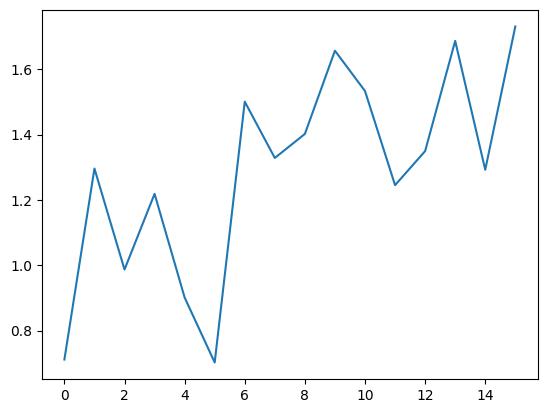

In [ ]:
plt.plot(sharpe_ratios)